# Practical Work: Fire Detection

In [3]:
import sys
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchsummary import summary

import matplotlib.pyplot as plt

from datasets import WildfirePredictionDataset
from models import UNet, Classifier

In [2]:
# Set random seed for reproducability and dataset splitting
torch.manual_seed(42)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [6]:
res = resnet18(weights=ResNet18_Weights.DEFAULT)
res.fc = nn.Sequential(
	nn.Linear(512, 128),
	nn.ReLU(),
	nn.Linear(128, 2),
)
summary(res, input_size=(3, 350, 350))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 175, 175]           9,408
       BatchNorm2d-2         [-1, 64, 175, 175]             128
              ReLU-3         [-1, 64, 175, 175]               0
         MaxPool2d-4           [-1, 64, 88, 88]               0
            Conv2d-5           [-1, 64, 88, 88]          36,864
       BatchNorm2d-6           [-1, 64, 88, 88]             128
              ReLU-7           [-1, 64, 88, 88]               0
            Conv2d-8           [-1, 64, 88, 88]          36,864
       BatchNorm2d-9           [-1, 64, 88, 88]             128
             ReLU-10           [-1, 64, 88, 88]               0
       BasicBlock-11           [-1, 64, 88, 88]               0
           Conv2d-12           [-1, 64, 88, 88]          36,864
      BatchNorm2d-13           [-1, 64, 88, 88]             128
             ReLU-14           [-1, 64,

In [5]:
res.fc

Linear(in_features=512, out_features=1000, bias=True)

## Exploring Data

In [ ]:
# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor()
])


# Load Wildfire Prediction Dataset dataset
dataset = WildfirePredictionDataset(split="valid", transform=transform)
print(len(dataset))

6300


torch.Size([3, 350, 350])
1


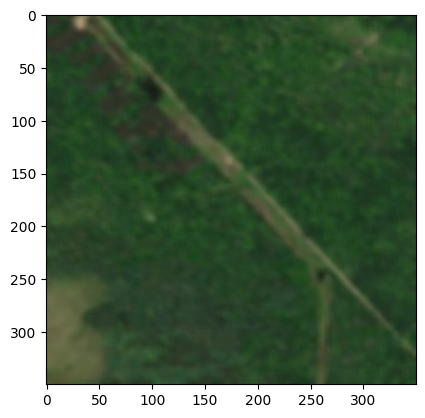

In [20]:
# %%script false --no-raise-error
# Check sample sizes
sample_id = torch.randint(len(dataset), size=(1,)).item()
img, label = dataset[sample_id]
print(img.shape)
print(label)
plt.imshow(img.permute(1, 2, 0))

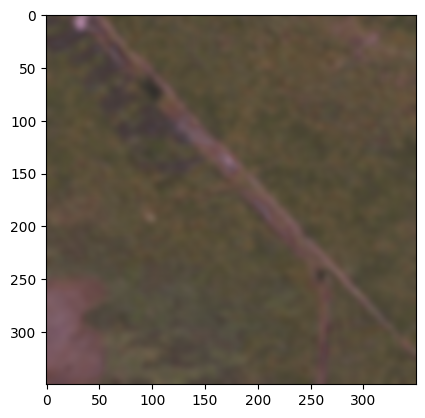

In [ ]:
transform_ = transforms.Compose([
	transforms.GaussianBlur(kernel_size=(11, 11), sigma=30)
])

transform_ = transforms.Compose([
	transforms.ColorJitter(brightness=random.random(),
						   contrast=random.random(),
						   saturation=random.random(),
						   hue=random.uniform(0, 0.5))
])

transform_ = transforms.Compose([
	transforms.GaussianBlur(kernel_size=(7, 7), sigma=(5,25)),
	transforms.ColorJitter(brightness=random.random(),
						   contrast=random.random(),
						   saturation=random.random(),
						   hue=random.uniform(0, 0.5))
])

transformed_img = transform_(img)
plt.imshow(transformed_img.permute(1, 2, 0))

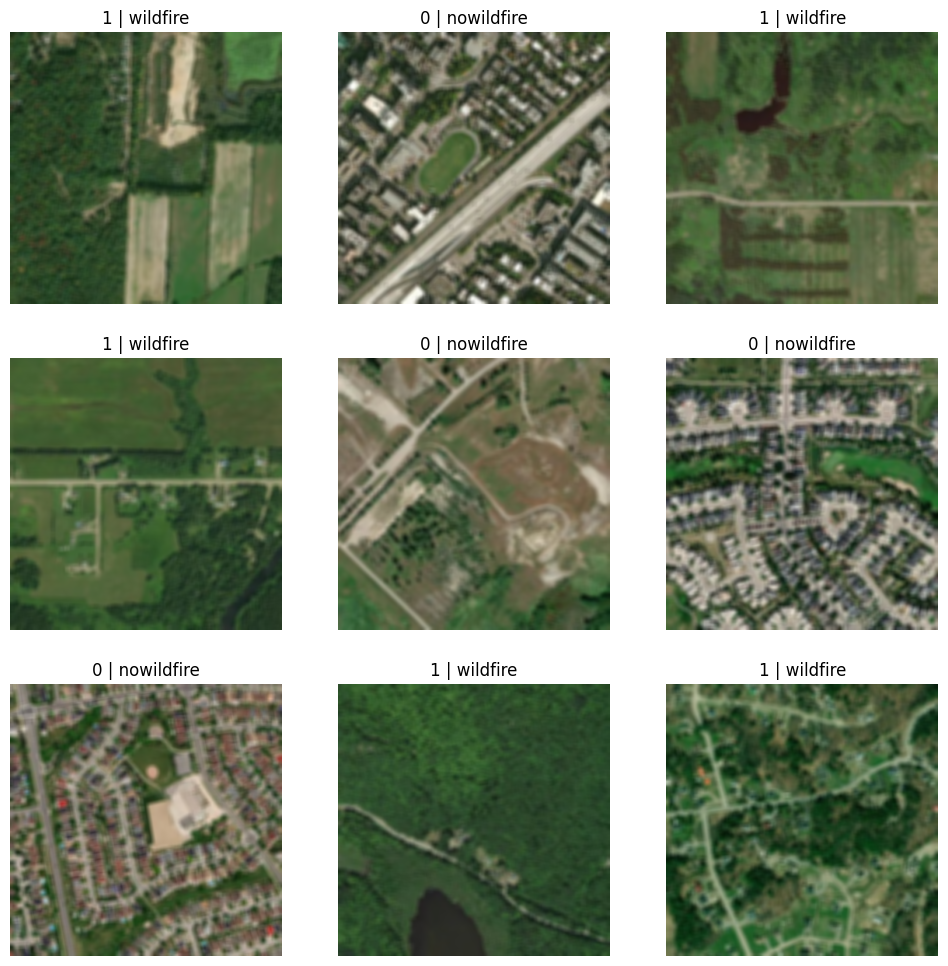

In [14]:
# %%script false --no-raise-error
# Plot images and labels
cols, rows = 3, 3
figure = plt.figure(figsize=(cols*4, rows*4))
for i in range(1, cols * rows + 1):
    sample_id = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_id]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label} | {dataset.labels_dict[label]}")
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

## Loading Data

In [ ]:
# Create training, validation and test data loaders
train_loader, valid_loader_1, valid_loader_2, test_loader = WildfirePredictionDataset.get_dataloaders(transform=transform, batch_size=16)

## SimCLR

### Image Reconstruction

In [ ]:
id = 000
reconstruction_net = UNet()
# checkpoint = torch.load(f"train_res/checkpoint_best.pth.tar", weights_only=True)
# model.load_state_dict(checkpoint)
# model = model.eval().to(device)

In [ ]:
%%script false --no-raise-error
summary(reconstruction_net, input_size=(3, 350, 350))

In [ ]:
batch_img, batch_label = next(iter(test_loader))
print(batch_img.shape)
# batch_encoder_out, batch_decoder_out = reconstruction_net(batch_img)

In [ ]:
# %%script false --no-raise-error
# Plot images and reconstruction
rows = 4
cols = 2
fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
for i in range(rows):
	sample_id = torch.randint(batch_img.shape[0], size=(1,)).item()
	img, label = batch_img[sample_id], batch_label[sample_id].item()
	reconstruction = batch_decoder_out[sample_id]

	axs[i,0].imshow(img.permute(1, 2, 0))
	axs[i,0].set_title(f"{label} | {dataset.labels_dict[label]}")
	axs[i,0].axis("off")

	axs[i,1].imshow(transforms.ToPILImage()(reconstruction.squeeze().cpu()))
	axs[i,1].axis("off")
    
plt.show()

### Image Classification

In [ ]:
id = 000
classifier_net = Classifier()
# checkpoint = torch.load(f"train_res/checkpoint_best.pth.tar", weights_only=True)
# model.load_state_dict(checkpoint)
# model = model.eval().to(device)

In [ ]:
%%script false --no-raise-error
summary(classifier_net, input_size=(3, 350, 350))